In [60]:
# importing libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
print('Libraries imported.')

Libraries imported.


In [61]:
# Getting the text of the webpage from the wikipedia link below.
raw_wikipedia_page= requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text

# using beautiful as done earlier in this course.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print('Data downloaded!')

Data downloaded!


In [62]:
# extracting the table from the imported text
table = soup.select_one('.wikitable:nth-of-type(5)')
print("Table extracted")

Table extracted


In [63]:
#Definition of empty dataframes
jurisdiction      = []
population_total   = []
black_or_african  = []

# Insert the table columns into the predefined dataframes
for tr_cell in table.find_all('tr'):
    
    # We define dummy variables which will be filled in the for loop.
    counter = 1
    name_var      = 'DUMMY'
    pop_var       = 'DUMMY'
    boa_var       = 'DUMMY'
    
    for td_cell in tr_cell.find_all('td'):
        if counter == 1: 
            name_var = td_cell.text
        if counter == 2: 
            pop_var = td_cell.text
            pop_var = pop_var.replace(",","")
        if counter == 4: 
            boa_var = str(td_cell.text).strip()
            
        counter +=1
        
    if boa_var!='DUMMY' and name_var!='\n':        
        jurisdiction.append(name_var)
        population_total.append(int(pop_var))
        black_or_african.append(float(boa_var))

In [64]:
#Quick check if all arrays have the same length:
print('length postcode:', len(jurisdiction))
print('length borough:', len(population_total))
print('length neighbourhood:', len(black_or_african))

length postcode: 8
length borough: 8
length neighbourhood: 8


In [65]:
dict = {'Borough':jurisdiction[0:5], 'Population 2000 census':population_total[0:5], 'black or African American in %':black_or_african[0:5]}
df = pd.DataFrame.from_dict(dict)
df.head()

,Borough,Population 2000 census,black or African American in %
0,Brooklyn,2465326,36.4
1,Queens,2229379,20.0
2,Manhattan,1537195,17.4
3,Bronx,1332650,35.6
4,Staten Island,443728,9.7


In [71]:
#Calculation of the total numbers from the importet data.
df['black or African American in total']=df['Population 2000 census']*df['black or African American in %']/100
df.head()

,Borough,Population 2000 census,black or African American in %,black or African American in total
0,Brooklyn,2465326,36.4,897378.664
1,Queens,2229379,20.0,445875.800
2,Manhattan,1537195,17.4,267471.930
3,Bronx,1332650,35.6,474423.400
4,Staten Island,443728,9.7,43041.616


We see that Brooklyn ist the borough with the highest percentage and also the highest number in total of black or African American population.

In [67]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
! pip install folium==0.5.0
import folium # plotting library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


In [9]:
#We define a function that returns us the latitude and longitude of a given address
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [13]:
#We define a function that returns us venues via the Foursquare API within a certain Radius. The radius is set to 1000m.
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'LXWLQKPWI5E1HY4LCA52MA0EM03D0YNZ3XPIJVN4YVZOI4PM'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='Z05LRPVVE0UGN2QAOPTP4QCK0SX51RERSXYYSP0KHFZVXOGS' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20210410' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df_out = pd.DataFrame(venue_details,columns=column_names)
    return df_out

In [14]:
# Under "https://cocl.us/new_york_dataset" the data of the neighbourhoods together with latitude and longitude can be found. The following procedure imports the data from the link. 
# The attributes we are interested in are 'Borough', 'Neighborhood', 'Latitude' and 'Longitude'
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # define the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [15]:
# get new york data
new_york_data=get_new_york_data()

In [16]:
new_york_data.head(20)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [17]:
new_york_data.shape

(306, 4)

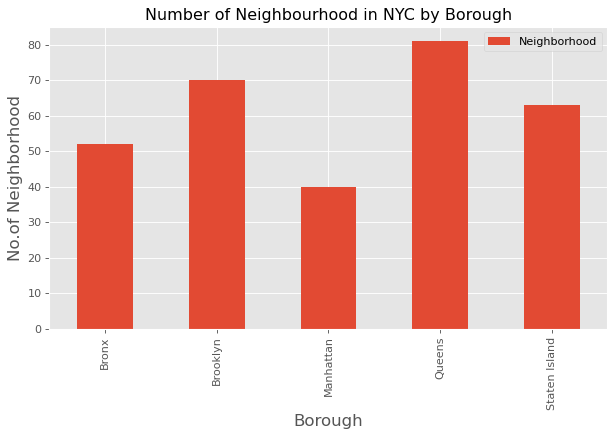

In [18]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [19]:
# In the following step we evaluate a list of neighborhood that contain african restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_resturants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(new_york_data),')','African Resturants in '+Neighborhood+', '+Borough+':'+str(len(african_resturants)))
    for resturant_detail in african_resturants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) African Resturants in Wakefield, Bronx:0
( 2 / 306 ) African Resturants in Co-op City, Bronx:0
( 3 / 306 ) African Resturants in Eastchester, Bronx:0
( 4 / 306 ) African Resturants in Fieldston, Bronx:0
( 5 / 306 ) African Resturants in Riverdale, Bronx:0
( 6 / 306 ) African Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) African Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) African Resturants in Woodlawn, Bronx:0
( 9 / 306 ) African Resturants in Norwood, Bronx:0
( 10 / 306 ) African Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) African Resturants in Baychester, Bronx:0
( 12 / 306 ) African Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) African Resturants in City Island, Bronx:0
( 14 / 306 ) African Resturants in Bedford Park, Bronx:0
( 15 / 306 ) African Resturants in University Heights, Bronx:1
( 16 / 306 ) African Resturants in Morris Heights, Bronx:0
( 17 / 306 ) African Resturants in Fordham, Bronx:1
( 18 / 306 ) African Resturants in East Tremont, Bronx:

( 141 / 306 ) African Resturants in Sunnyside, Queens:0
( 142 / 306 ) African Resturants in East Elmhurst, Queens:0
( 143 / 306 ) African Resturants in Maspeth, Queens:0
( 144 / 306 ) African Resturants in Ridgewood, Queens:0
( 145 / 306 ) African Resturants in Glendale, Queens:0
( 146 / 306 ) African Resturants in Rego Park, Queens:0
( 147 / 306 ) African Resturants in Woodhaven, Queens:0
( 148 / 306 ) African Resturants in Ozone Park, Queens:0
( 149 / 306 ) African Resturants in South Ozone Park, Queens:0
( 150 / 306 ) African Resturants in College Point, Queens:0
( 151 / 306 ) African Resturants in Whitestone, Queens:0
( 152 / 306 ) African Resturants in Bayside, Queens:0
( 153 / 306 ) African Resturants in Auburndale, Queens:0
( 154 / 306 ) African Resturants in Little Neck, Queens:0
( 155 / 306 ) African Resturants in Douglaston, Queens:0
( 156 / 306 ) African Resturants in Glen Oaks, Queens:0
( 157 / 306 ) African Resturants in Bellerose, Queens:0
( 158 / 306 ) African Resturants

( 276 / 306 ) African Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) African Resturants in Flatiron, Manhattan:0
( 278 / 306 ) African Resturants in Sunnyside Gardens, Queens:0
( 279 / 306 ) African Resturants in Blissville, Queens:0
( 280 / 306 ) African Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) African Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) African Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) African Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) African Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) African Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) African Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) African Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) African Resturants in Egbertville, Staten Island:0
( 289 / 306 ) African Resturants in Roxbury, Queens:0
( 290 / 306 ) African Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) African Resturants in Middle Village, Queens:0
( 292 / 306 ) Afric

In [73]:
african_rest_ny.head(5)

,Borough,Neighborhood,ID,Name
0,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
1,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
2,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
3,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix
4,Manhattan,Hamilton Heights,53e01975498e78c0915599bf,Ponty Bistro Harlem


In [36]:
african_rest_ny_unique=african_rest_ny.drop(columns=['Neighborhood'])
african_rest_ny_unique=african_rest_ny_unique.drop_duplicates()

In [74]:
african_rest_ny_unique.head(5)

,Borough,ID,Name
0,Bronx,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
3,Brooklyn,51d4d2cc454a777ed5a76c57,Cafe Rue Dix
4,Manhattan,53e01975498e78c0915599bf,Ponty Bistro Harlem
6,Manhattan,4c2fdced452620a120551e0f,Keur Sokhna
7,Manhattan,5004a9e5e4b034c2950659fd,Les Ambassades Senegalais Bistro


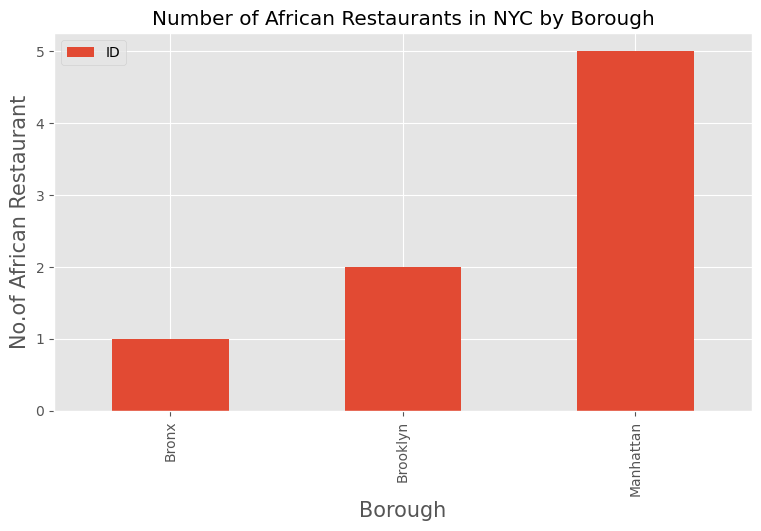

In [75]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Restaurant', fontsize=15)
#giving a bar plot
african_rest_ny_unique.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [68]:
df_num_african=african_rest_ny.groupby(['Borough']).size().reset_index()
df_num_african.rename(columns={0: 'Count'}, inplace = True)
df_num_african.head()

,Borough,Count
0,Bronx,3
1,Brooklyn,2
2,Manhattan,6


In [72]:
df_totat = pd.merge(df,df_num_african,on='Borough',how='left')
df_totat.head(10)

,Borough,Population 2000 census,black or African American in %,black or African American in total,Count
0,Brooklyn,2465326,36.4,897378.664,2.0
1,Queens,2229379,20.0,445875.800,NaN
2,Manhattan,1537195,17.4,267471.930,6.0
3,Bronx,1332650,35.6,474423.400,3.0
4,Staten Island,443728,9.7,43041.616,NaN
